In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, random, arange
from IPython.display import display, HTML
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import shap
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,KFold


import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor


In [2]:
data = pd.read_excel('System_Descriptors.xlsx',decimal=',')

In [3]:
data.columns = [r'$UCC$',
           r'$SG$',
           r'$Z^M$',
           r'$P^M$',
           r'$G^M$',
           r'$r_0^M$',
           r'$\bar{q}_s^M$',
           r'$\bar{q}_d^M$',
           r'$\bar{q}_p^M$',
           r'$\bar{q}_f^M$',
           r'$\bar{q}_I^M$',
           r'$\bar{q}_B^M$',
           r'$\bar{q}_{B,A}^M$',
           r'$Z^Q$',
           r'$P^Q$',
           r'$G^Q$',
           r'$r_0^Q$',
           r'$\bar{q}_s^Q$',
           r'$\bar{q}_d^Q$',
           r'$\bar{q}_p^Q$',
           r'$\bar{q}_f^Q$',
           r'$\bar{q}_I^Q$',
           r'$\bar{q}_B^Q$',
           r'$\bar{q}_{B,A}^Q$',
           r'$a_0$',
           r'$b_0$',
           r'$\gamma$',
           r'$\Omega_{u.c.}$',
           r'$\bar{d}^{MQ}$',
           r'$E_g^{\Gamma}$',
           r'$\Phi$',
           r'$q_I$',
           r'$E_\mathrm{tot}^{f.u.}$',
           r'$\Delta E_\mathrm{tot}^{f.u.}$',
           r'$\Delta H$',
           r'$E_\mathrm{coh.}$',
          ]

In [4]:
ids = [r'$UCC$',
       r'$SG$']

In [5]:
m = [      r'$Z^M$',
           r'$P^M$',
           r'$G^M$',
           r'$r_0^M$',
           r'$\bar{q}_s^M$',
           r'$\bar{q}_d^M$',
           r'$\bar{q}_p^M$',
           r'$\bar{q}_f^M$',
           r'$\bar{q}_I^M$',
           r'$\bar{q}_B^M$',
           r'$\bar{q}_{B,A}^M$'
]

In [6]:
q = [      r'$Z^Q$',
           r'$P^Q$',
           r'$G^Q$',
           r'$r_0^Q$',
           r'$\bar{q}_s^Q$',
           r'$\bar{q}_d^Q$',
           r'$\bar{q}_p^Q$',
           r'$\bar{q}_f^Q$',
           r'$\bar{q}_I^Q$',
           r'$\bar{q}_B^Q$',
           r'$\bar{q}_{B,A}^Q$'
]

In [7]:
propriedades = [r'$a_0$',
           r'$b_0$',
           r'$\gamma$',
           r'$\Omega_{u.c.}$',
           r'$\bar{d}^{MQ}$',
           r'$E_g^{\Gamma}$',
           r'$\Phi$',
           r'$q_I$'
]

In [8]:
targets = [r'$E_\mathrm{tot}^{f.u.}$',
           r'$\Delta E_\mathrm{tot}^{f.u.}$',
           r'$\Delta H$',
           r'$E_\mathrm{coh.}$'

            ]

In [9]:
models = {}
shap_values = {}
preds = {}

for target in tqdm(targets):
    models[target] = RandomForestRegressor(
        #tree_method = 'auto',
        #enable_categorical=True
    )
    models[target].fit(data[m+q+propriedades],data[target]) 

    #n_splits = 5
    #cv = StratifiedKFold(n_splits=n_splits).split(data,data[r'$UCC$'])
    #if target == r'$\Delta E_\mathrm{tot}^{f.u.}$': 
    #    r = cross_val_score(clf2, data[m+q+propriedades], data[target]+min(data[target])+1e-10, cv=cv,scoring='r2')
    #else:
    #    r = cross_val_score(clf1, data[m+q+propriedades], data[target]+min(data[target])+1e-10, cv=cv,scoring='r2')
        
    #print(sum(r)/n_splits)
    r = models[target].score(data[m+q+propriedades],data[target])
    preds[target] = models[target].predict(data[m+q+propriedades])
    print(r)
    explainer = shap.TreeExplainer(models[target])
    #explainer = shap.explainers.Linear(models[target],shap.maskers.Independent(data[m+q+propriedades]))
    shap_values[target] = explainer(data[m+q+propriedades])

  0%|          | 0/4 [00:00<?, ?it/s]

0.9946807504848445
0.9693832588053841
0.992364496464599
0.9950249173507099


In [10]:
model =  RandomForestRegressor()


c1 = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
c2 = ['squared_error', 'absolute_error', 'friedman_mse']

scores = {}
predictions = {}

for target in tqdm(targets[2:]):

    scores[target] = []
 
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits)
    predictions[target] = np.zeros(len(data))
    
    for i, (train_index, test_index) in enumerate(skf.split(data,data[r'$UCC$'])):
        skf2 = StratifiedKFold(n_splits=5).split(data.iloc[train_index],data[r'$UCC$'].iloc[train_index])

        if target == r'$\Delta E_\mathrm{tot}^{f.u.}$':
            c = c1
        else:
            c = c2
        
        clf = GridSearchCV(
            model,
            {
                #"criterion" : c,
                "n_estimators": [50,100,300,500,700],
            },
            verbose=1,
            cv = 5
        )
 
        best_model = clf.fit(data.iloc[train_index][m+q+propriedades], data.iloc[train_index][target])
        scores[target].append(best_model.score(data.iloc[test_index][m+q+propriedades],data.iloc[test_index][target]))
        predictions[target][test_index] = best_model.predict(data.iloc[test_index][m+q+propriedades])
    print(np.mean(scores[target]))
        
        

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9172990881306665
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9569479358723495


In [11]:
predictions = pd.DataFrame(preds)

In [12]:
predictions.columns = [r'$\widehat{E_\mathrm{tot}^{f.u.}}$',
           r'$\widehat{\Delta E_\mathrm{tot}^{f.u.}}$',
           r'$\widehat{\Delta H}$',
           r'$\widehat{E_\mathrm{coh.}}$'
            ]

In [13]:
plt.rcParams['font.size'] = 25

0it [00:00, ?it/s]

/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

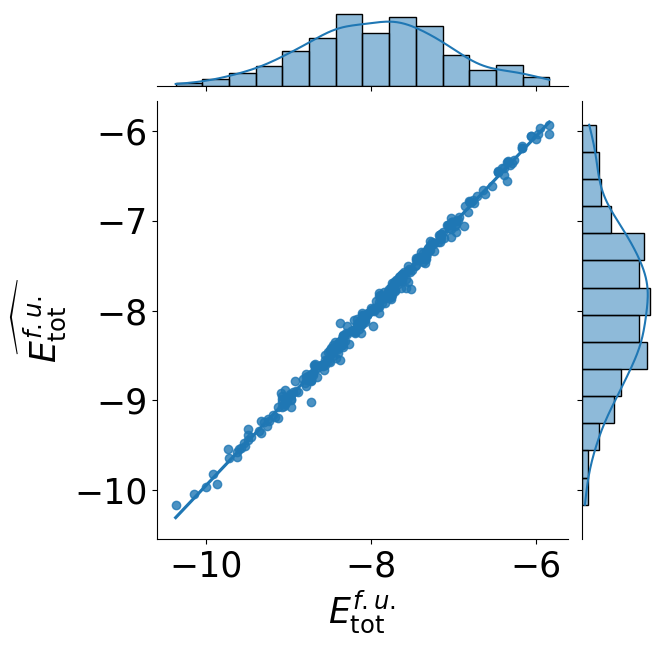

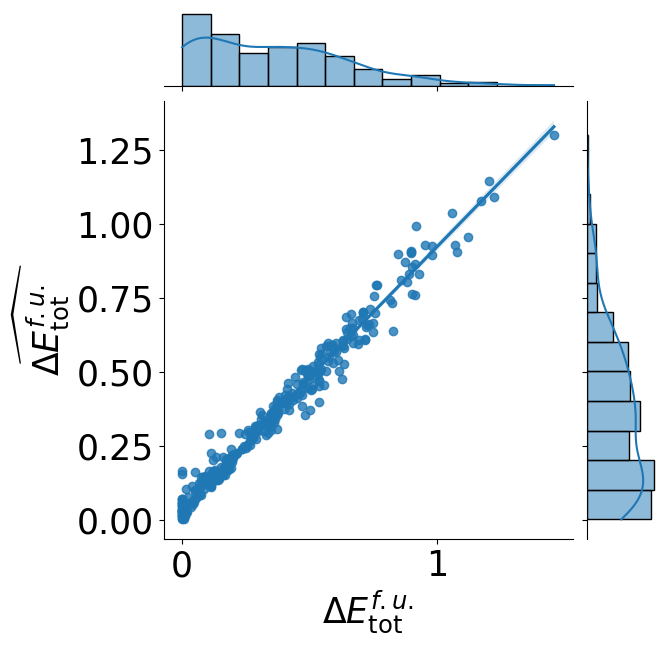

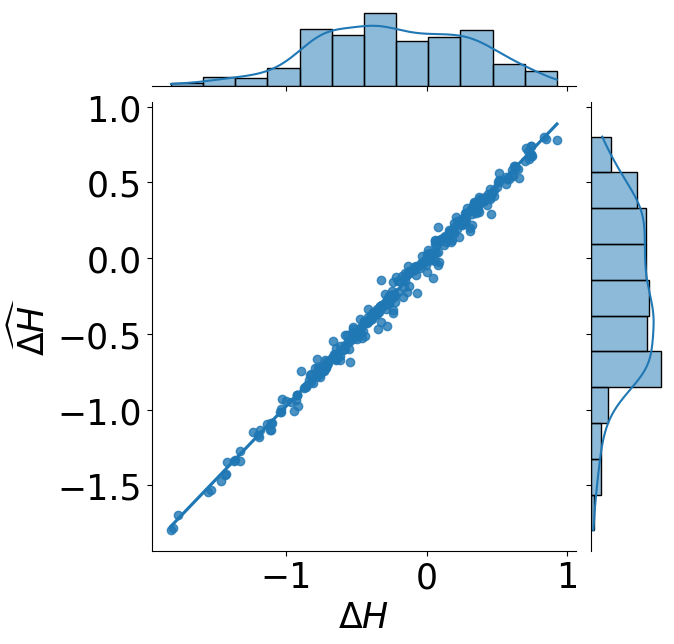

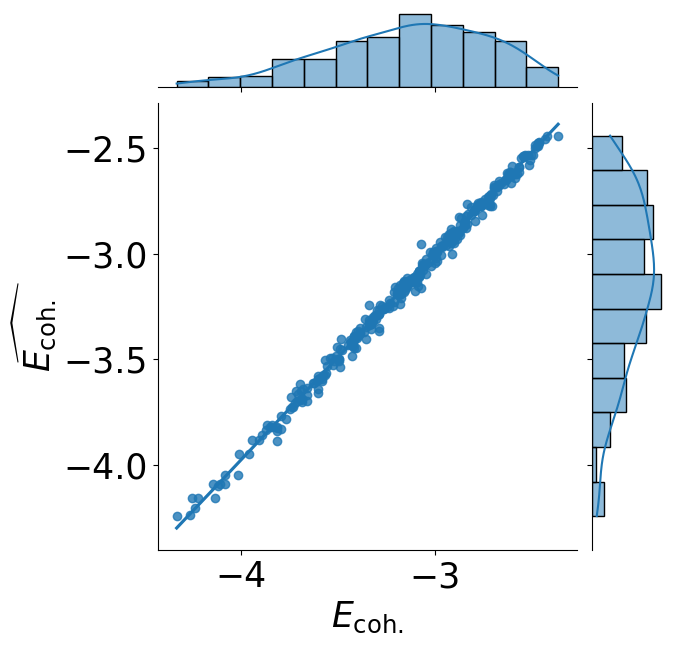

In [14]:
for i, (target, pred) in tqdm(enumerate(zip(targets,predictions.columns))):
    g = sns.jointplot(x=data[target], y=predictions[pred], 
                  kind="reg", 
                height=7)
    #g.ax_joint.plot([data[target].min(),data[target].max()],[data[target].min(),data[target].max()],'b-',linewidth=2) 
    plt.savefig(str(i)+"_train.pdf",bbox_inches='tight')

0it [00:00, ?it/s]

/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ronaldo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

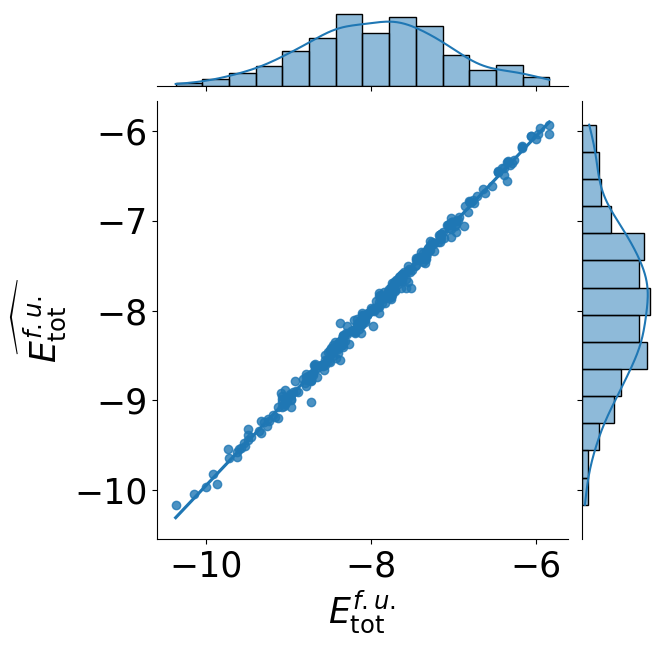

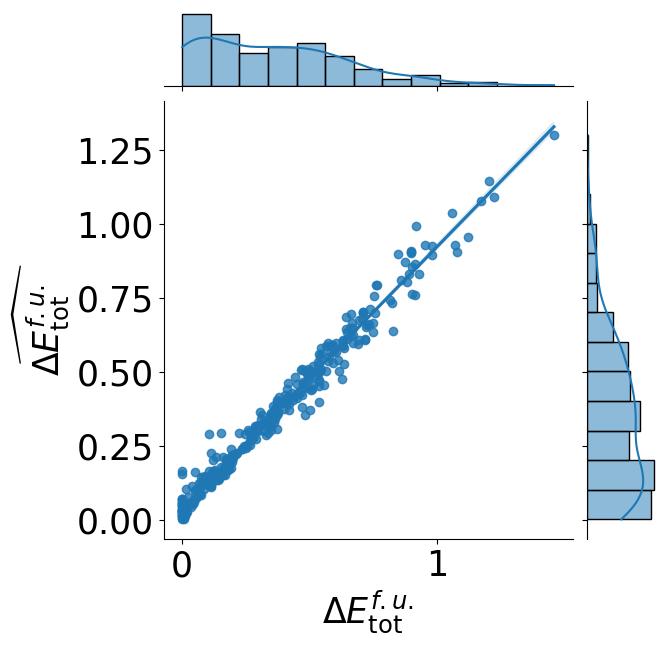

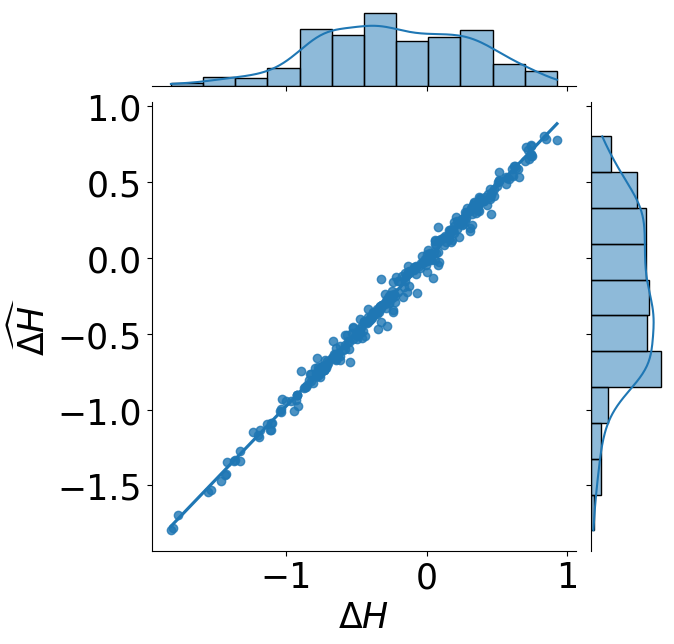

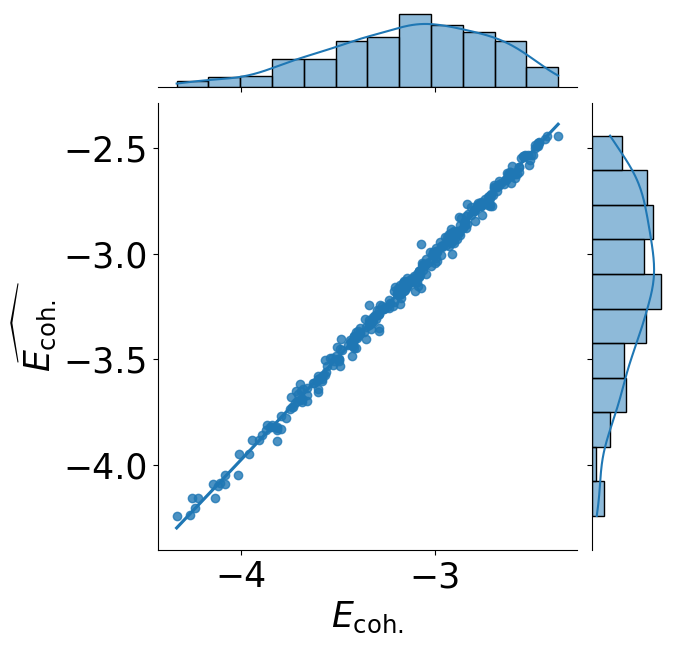

In [15]:
for i, (target, pred) in tqdm(enumerate(zip(targets,predictions.columns))):
    g = sns.jointplot(x=data[target], y=predictions[pred], 
                  kind="reg", 
                height=7)
    #g.ax_joint.plot([data[target].min(),data[target].max()],[data[target].min(),data[target].max()],'b-',linewidth=2) 
    plt.savefig(str(i)+".pdf",bbox_inches='tight')

$E_\mathrm{tot}^{f.u.}$
$\Delta E_\mathrm{tot}^{f.u.}$
$\Delta H$
$E_\mathrm{coh.}$


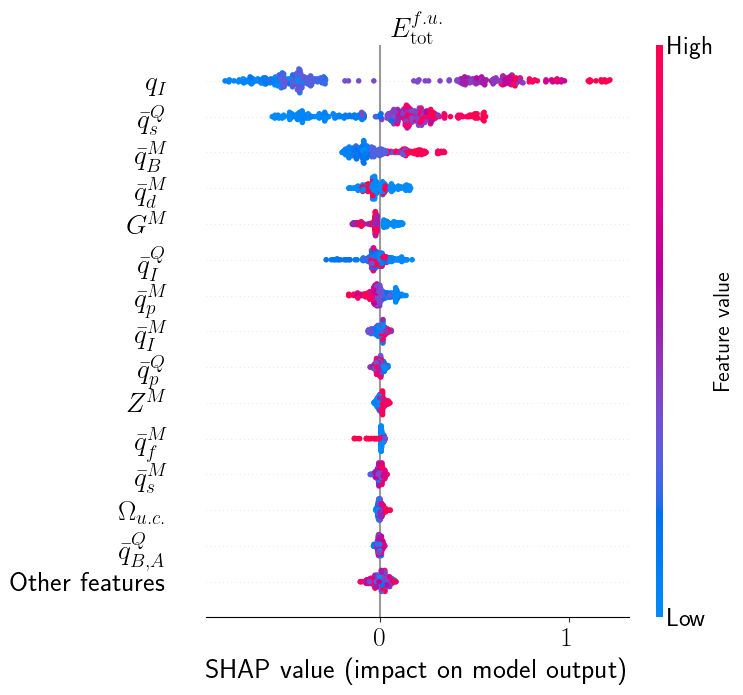

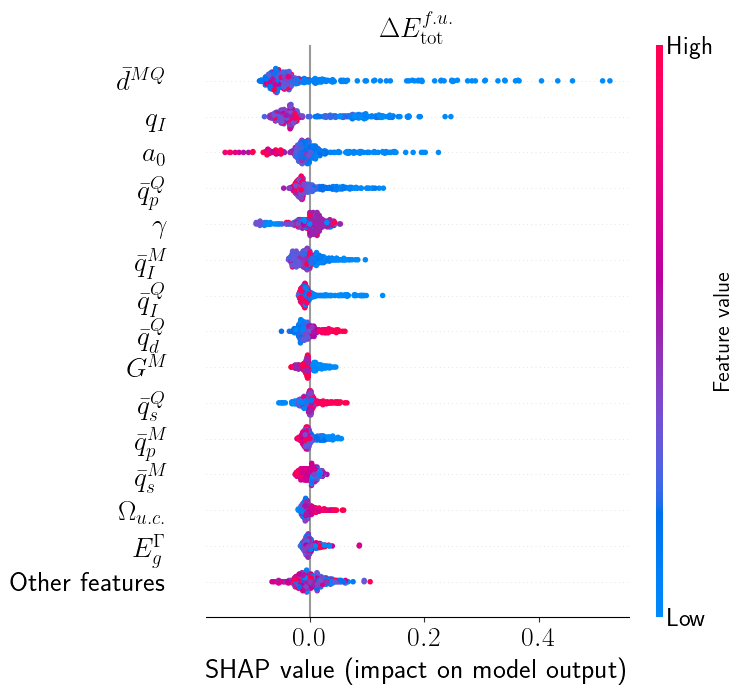

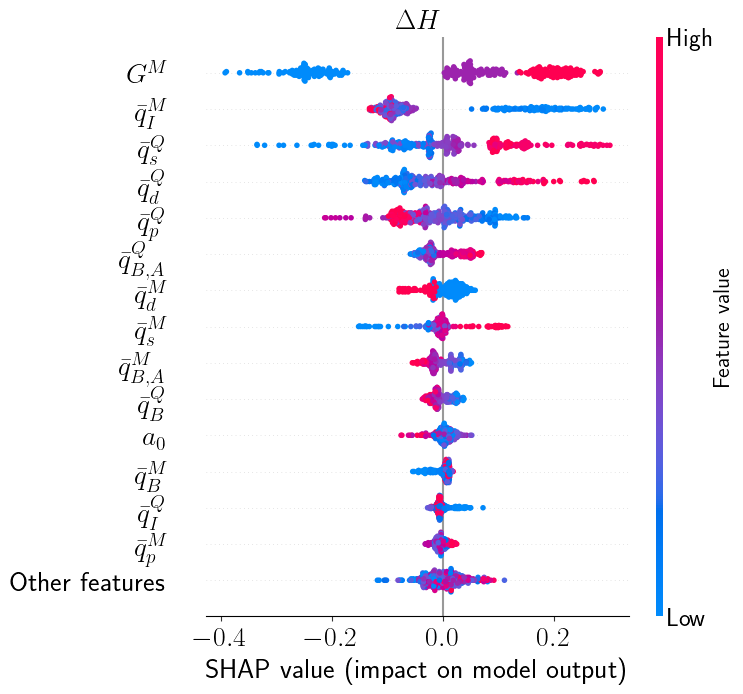

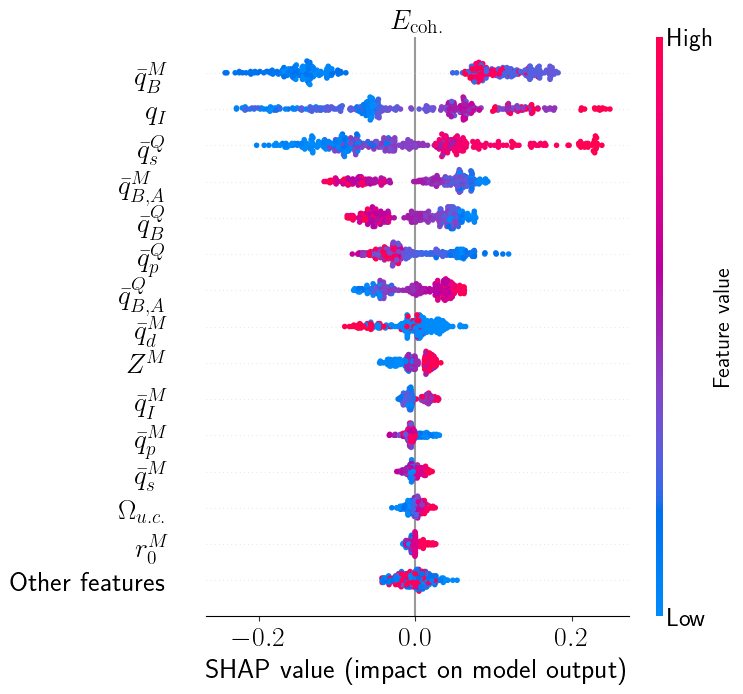

In [21]:

plt.rcParams['text.usetex'] = True

names = ['M','Q','Properties'] 
feat = m + q + propriedades
#fig, axs = plt.subplots(2, 2,figsize=(25, 10))    
for i, target in enumerate(targets):
    print(target)
    fig = plt.figure()
    #plt.sca(fig)
    plt.title(target,fontsize=28)
    ax = shap.plots.beeswarm(shap_values[target][:,feat],max_display=15,show=False)   
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 
        item.set_color('black')
        item.set_alpha(1)
    plt.tight_layout()
    plt.savefig(str(i)+'.pdf')
    